In [23]:
%load_ext autoreload
%autoreload 2

import os
import sys
from typing import OrderedDict
import torch
from PIL import Image
from torch.utils.data import DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import nltk
nltk.download('punkt_tab')

# Add parent directory to the system path
script_dir = os.path.dirname(os.path.abspath(""))
sys.path.append(os.path.dirname(script_dir))

from data.dataset import FlickrDataset, collate_fn, get_transform
from data.preprocessing import (
    build_vocabulary,
    convert_captions_to_sequences,
    get_splits,
    prepare_image2captions,
)
import pandas as pd

dataset = "Flickr8k"
dataset_dir = f"../../flickr_data/{dataset}_Dataset/Images"
captions_file = f"../../flickr_data/{dataset}_Dataset/captions.txt"
image_dir = dataset_dir

# Load captions
caption_df = pd.read_csv(captions_file).dropna().drop_duplicates()
print(f"Total captions loaded: {len(caption_df)}")

# Build vocabulary
word2idx, idx2word, image_captions = build_vocabulary(caption_df, vocab_size=5000)
print(f"Vocabulary size: {len(word2idx)}")

# Convert captions to sequences
captions_seqs, max_length = convert_captions_to_sequences(image_captions, word2idx)
print(f"Maximum caption length: {max_length}")

image_names = list(image_captions.keys())
train_images, val_images, _ = get_splits(image_names, test_size=0.3)
image_names = list(image_captions.keys())

train_transform = get_transform(train=True)
# Create datasets and data loaders
train_dataset = FlickrDataset(
    image_dir, train_images, captions_seqs, transform=train_transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=2,
)

model = fasterrcnn_resnet50_fpn(weights="COCO_V1")
model.eval()
backbone = model.backbone
rpn = model.rpn
roi_heads = model.roi_heads
transform = model.transform

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Total captions loaded: 40445


[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/ivankoh/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Vocabulary size: 5000
Maximum caption length: 40


In [24]:
images = next(iter(train_loader))
# extract 1 batch and flatten the batch dimension
images = images[0]

with torch.no_grad(): 
    transformed_images, _ = transform(images)
    features = backbone(transformed_images.tensors)
    if isinstance(features, torch.Tensor):
        features = OrderedDict([("0", features)])
    proposals, _ = rpn(transformed_images, features, None)
    detections, _ = roi_heads(features, proposals, transformed_images.image_sizes, None)a

box_features = roi_heads.box_roi_pool(
    features, proposals, transformed_images.image_sizes
)
box_features = roi_heads.box_head(box_features)  # the bottom up features

class_logits, box_regression = roi_heads.box_predictor(box_features)
boxes, scores, labels = roi_heads.postprocess_detections(
    class_logits, box_regression, proposals, transformed_images.image_sizes
)

# sanity check to make sure we are getting the bottom up features correctly
for i, d in enumerate(detections):
    box = d["boxes"]
    score = d["scores"]
    label = d["labels"]
    assert torch.allclose(boxes[i], box), "The boxes are not the same"
    assert torch.allclose(scores[i], score), "The scores are not the same"
    assert torch.allclose(labels[i], label), "The labels are not the same"

print("All tests passed!")

batch_size = len(images)
print(f"batch size: {batch_size}")
original_image_sizes = [(256,256)] * batch_size
detections = transform.postprocess(detections, transformed_images.image_sizes, original_image_sizes)

All tests passed!
batch size: 32


image shape: torch.Size([3, 224, 224])
image shape: (256, 256, 3)
No detections found for image 0 after confidence filtering.
image shape: torch.Size([3, 224, 224])
image shape: (256, 256, 3)
No detections found for image 1 after confidence filtering.
image shape: torch.Size([3, 224, 224])
image shape: (256, 256, 3)
No detections found for image 2 after confidence filtering.
image shape: torch.Size([3, 224, 224])
image shape: (256, 256, 3)
No detections found for image 3 after confidence filtering.
image shape: torch.Size([3, 224, 224])
image shape: (256, 256, 3)
No detections found for image 4 after confidence filtering.
image shape: torch.Size([3, 224, 224])
image shape: (256, 256, 3)
dimensions of image (256, 256, 3)
box coordinates: (126.83925, 75.534645, 139.2299, 108.27767)


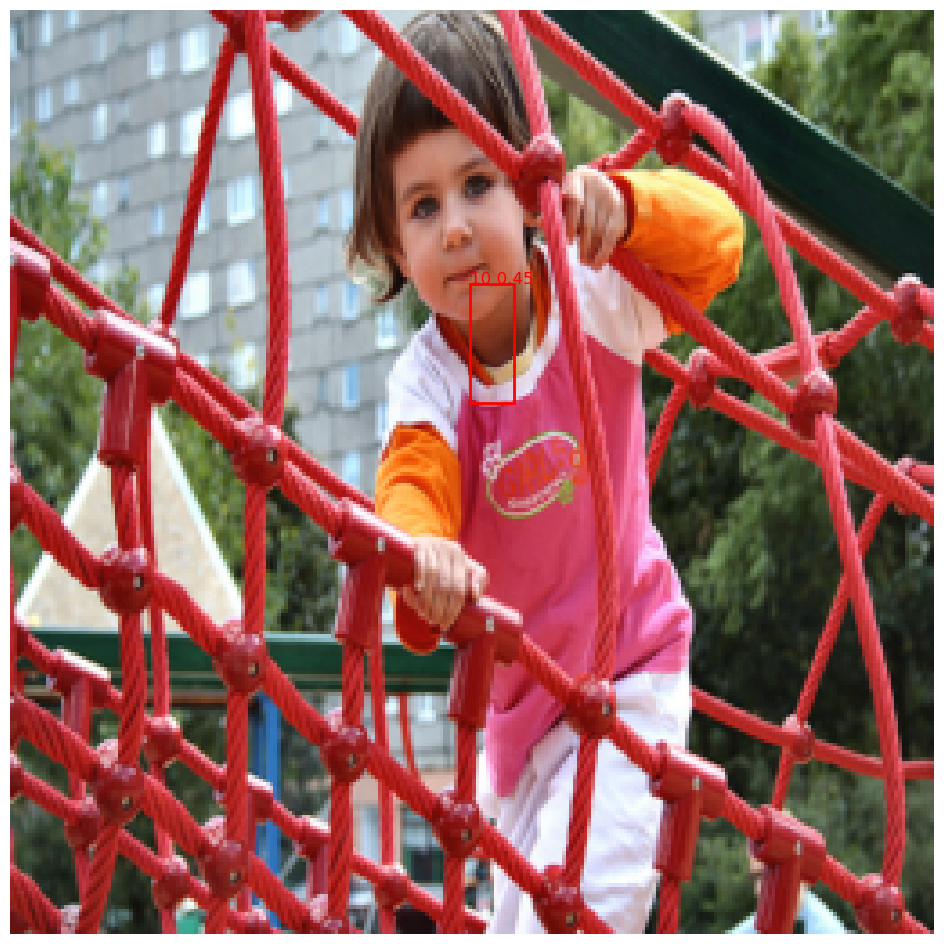

image shape: torch.Size([3, 224, 224])
image shape: (256, 256, 3)
No detections found for image 6 after confidence filtering.
image shape: torch.Size([3, 224, 224])
image shape: (256, 256, 3)
dimensions of image (256, 256, 3)
box coordinates: (9.844091, 45.56158, 241.82245, 251.67094)


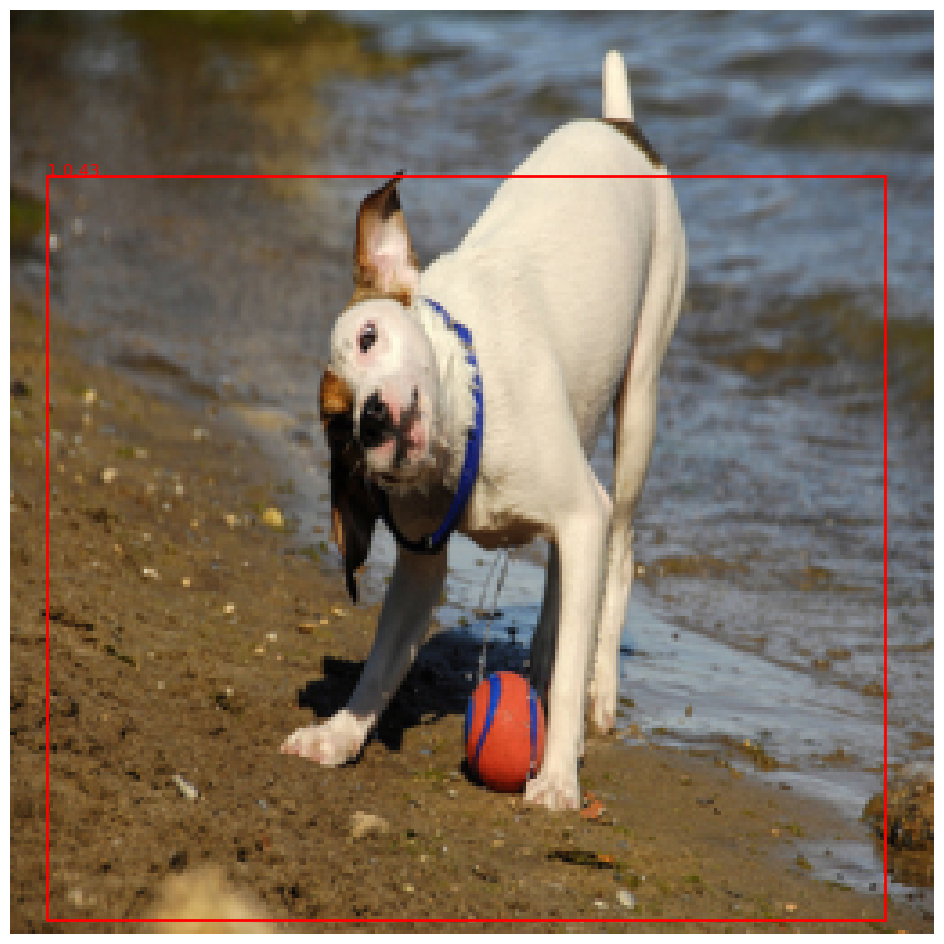

image shape: torch.Size([3, 224, 224])
image shape: (256, 256, 3)
No detections found for image 8 after confidence filtering.
image shape: torch.Size([3, 224, 224])
image shape: (256, 256, 3)
No detections found for image 9 after confidence filtering.
image shape: torch.Size([3, 224, 224])
image shape: (256, 256, 3)
dimensions of image (256, 256, 3)
box coordinates: (47.42583, 137.4044, 87.53422, 156.05899)
box coordinates: (31.671947, 145.81758, 56.92802, 156.46442)


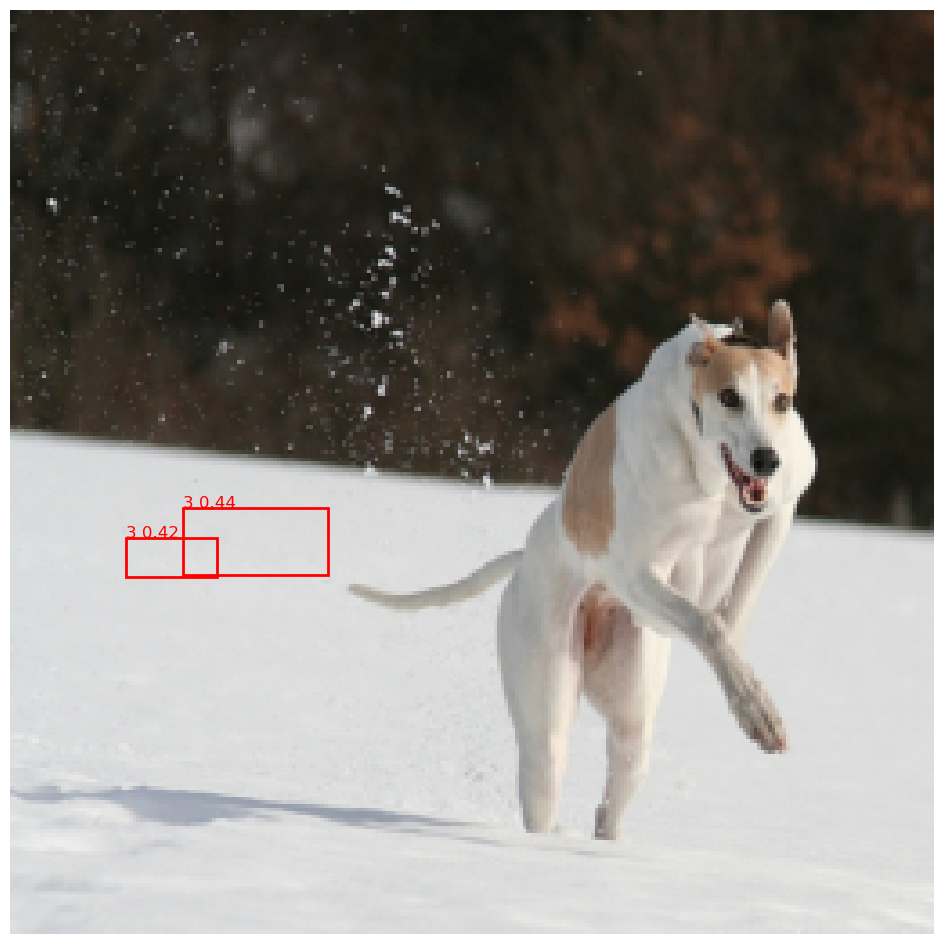

image shape: torch.Size([3, 224, 224])
image shape: (256, 256, 3)
dimensions of image (256, 256, 3)
box coordinates: (13.846965, 104.09127, 64.84405, 146.11888)


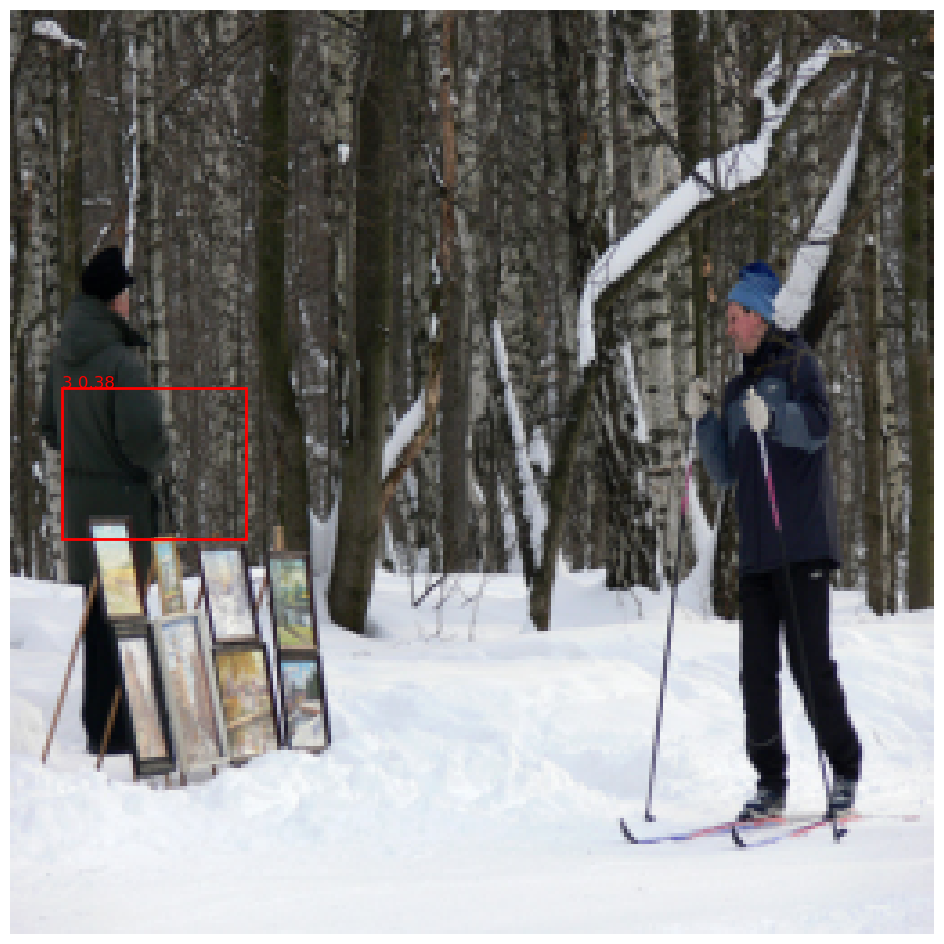

image shape: torch.Size([3, 224, 224])
image shape: (256, 256, 3)
No detections found for image 12 after confidence filtering.
image shape: torch.Size([3, 224, 224])
image shape: (256, 256, 3)
dimensions of image (256, 256, 3)
box coordinates: (116.316055, 137.60443, 128.80293, 175.34572)
box coordinates: (120.118065, 180.19838, 140.16505, 205.47595)


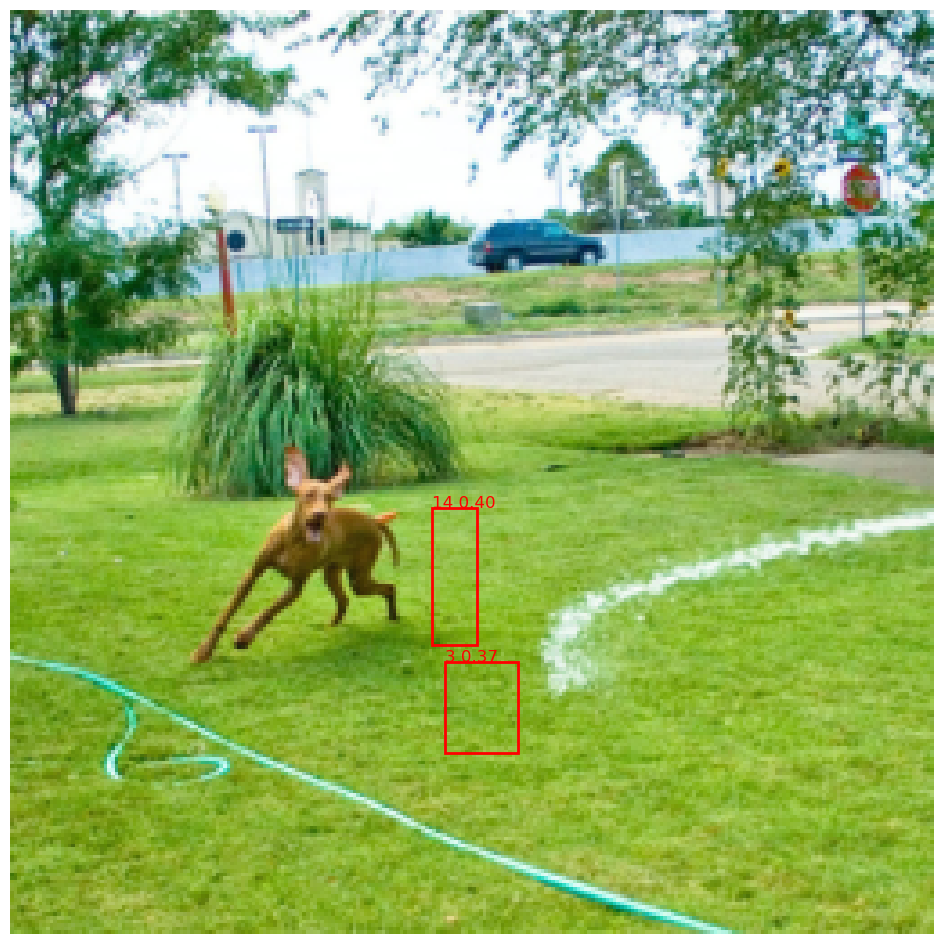

image shape: torch.Size([3, 224, 224])
image shape: (256, 256, 3)
No detections found for image 14 after confidence filtering.
image shape: torch.Size([3, 224, 224])
image shape: (256, 256, 3)
No detections found for image 15 after confidence filtering.
image shape: torch.Size([3, 224, 224])
image shape: (256, 256, 3)
dimensions of image (256, 256, 3)
box coordinates: (106.710526, 131.59633, 123.96316, 161.21367)


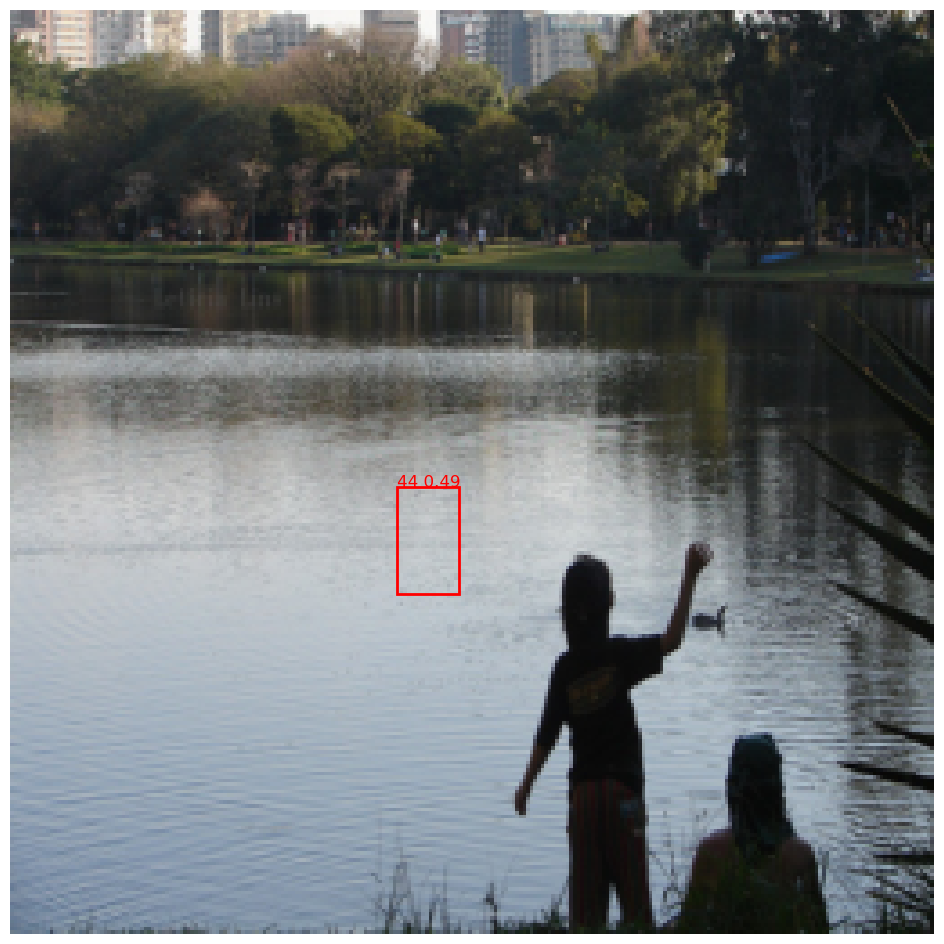

image shape: torch.Size([3, 224, 224])
image shape: (256, 256, 3)
No detections found for image 17 after confidence filtering.
image shape: torch.Size([3, 224, 224])
image shape: (256, 256, 3)
No detections found for image 18 after confidence filtering.
image shape: torch.Size([3, 224, 224])
image shape: (256, 256, 3)
No detections found for image 19 after confidence filtering.
image shape: torch.Size([3, 224, 224])
image shape: (256, 256, 3)
dimensions of image (256, 256, 3)
box coordinates: (28.886879, 118.8525, 42.015003, 131.8847)


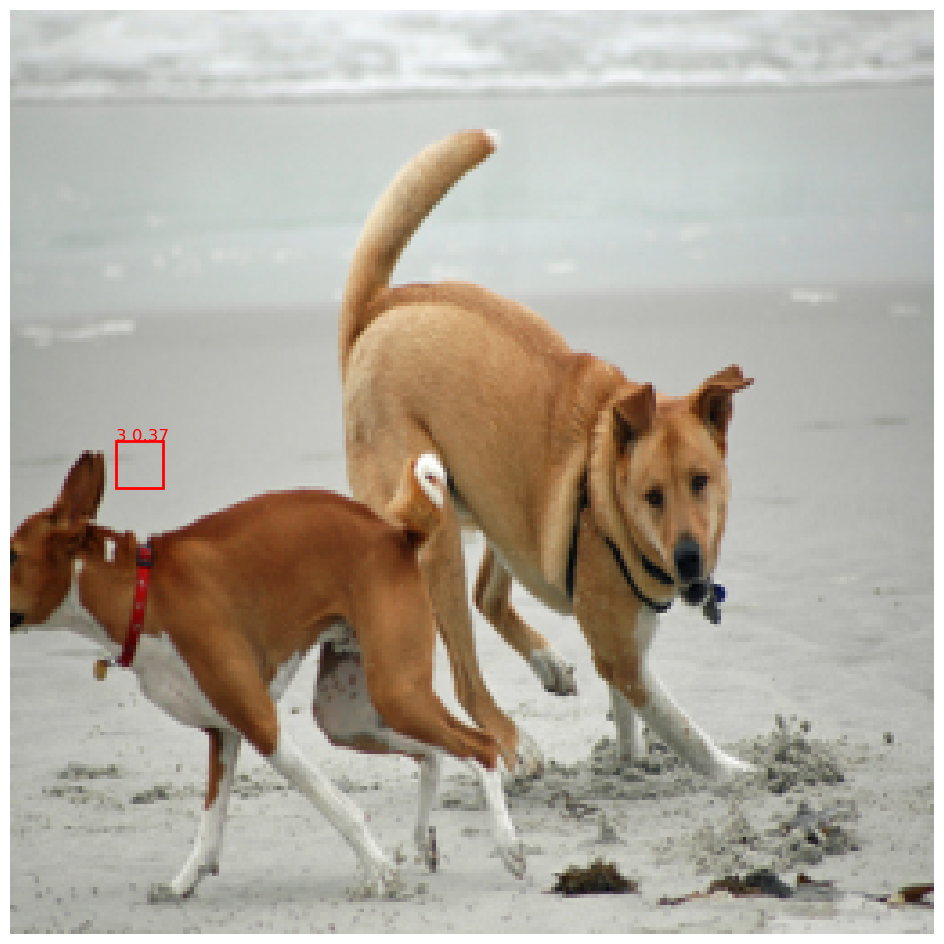

image shape: torch.Size([3, 224, 224])
image shape: (256, 256, 3)
dimensions of image (256, 256, 3)
box coordinates: (63.921463, 117.515076, 113.15302, 252.74663)
box coordinates: (29.387148, 44.710625, 51.33613, 71.270096)
box coordinates: (139.88776, 153.00795, 195.83186, 250.21782)


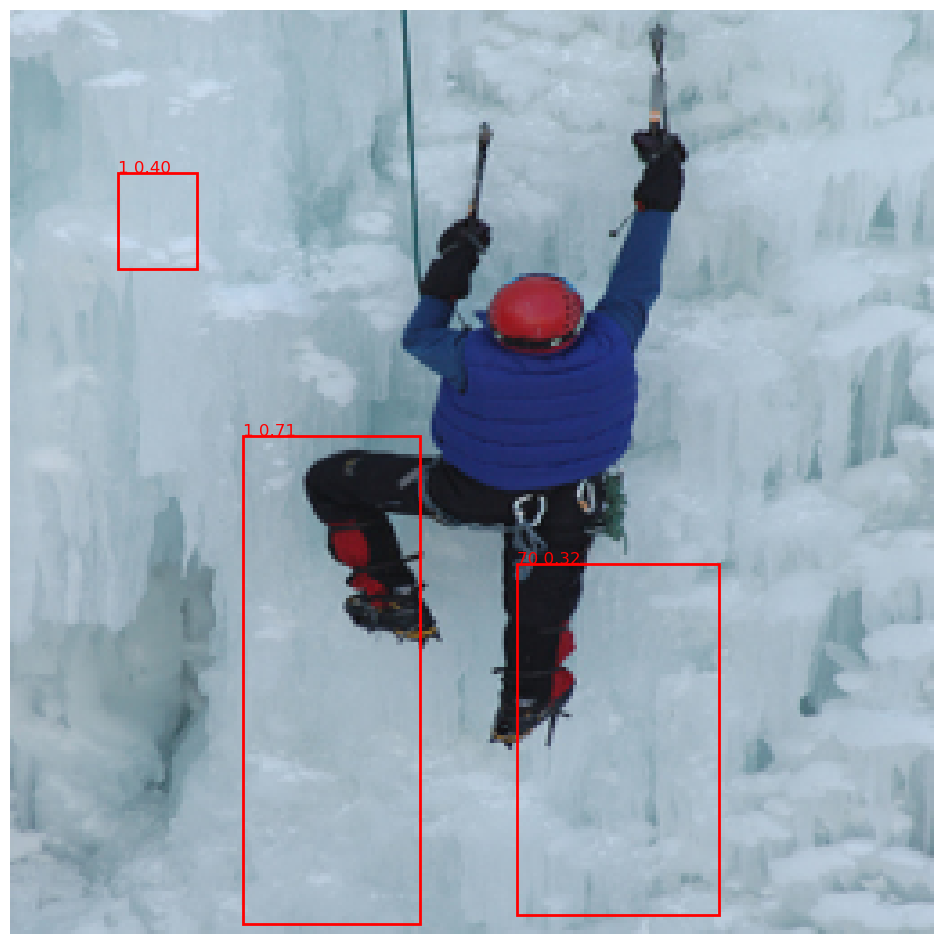

image shape: torch.Size([3, 224, 224])
image shape: (256, 256, 3)
No detections found for image 22 after confidence filtering.
image shape: torch.Size([3, 224, 224])
image shape: (256, 256, 3)
No detections found for image 23 after confidence filtering.
image shape: torch.Size([3, 224, 224])
image shape: (256, 256, 3)
dimensions of image (256, 256, 3)
box coordinates: (6.131328, 0.0, 191.97014, 256.0)


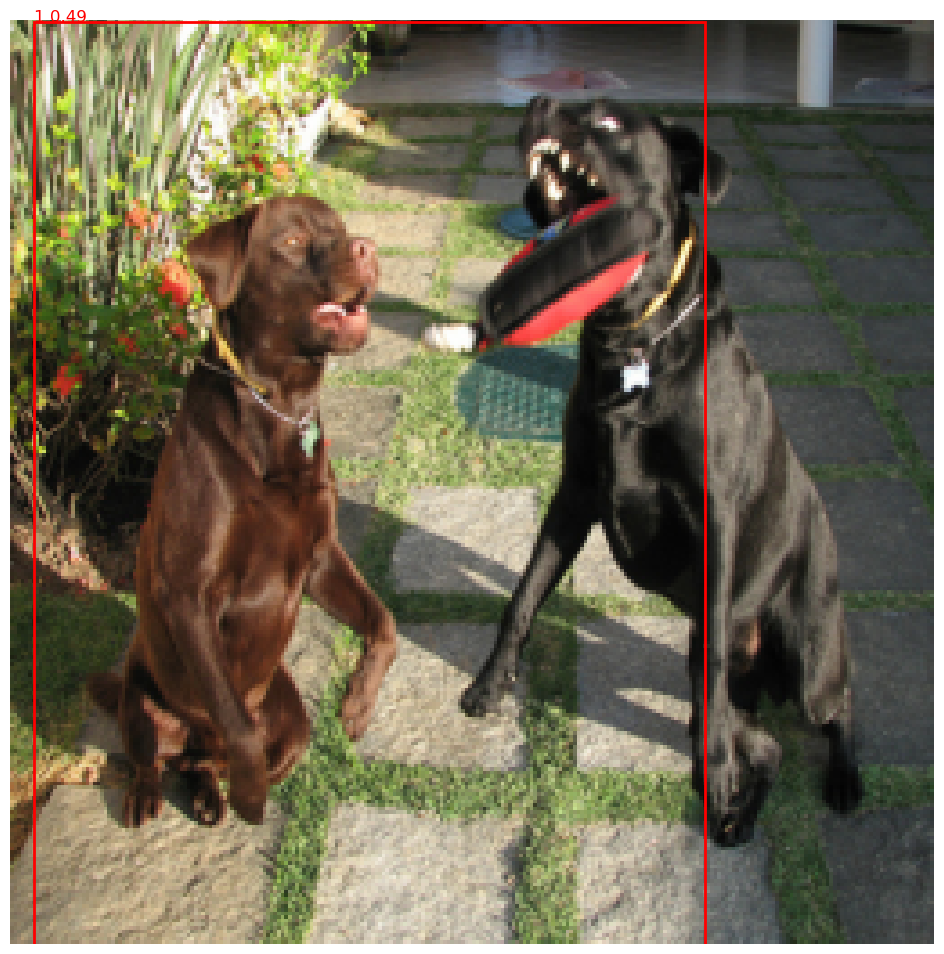

image shape: torch.Size([3, 224, 224])
image shape: (256, 256, 3)
dimensions of image (256, 256, 3)
box coordinates: (175.64058, 78.53109, 188.52054, 103.53578)
box coordinates: (117.55247, 39.19334, 122.50454, 53.541767)


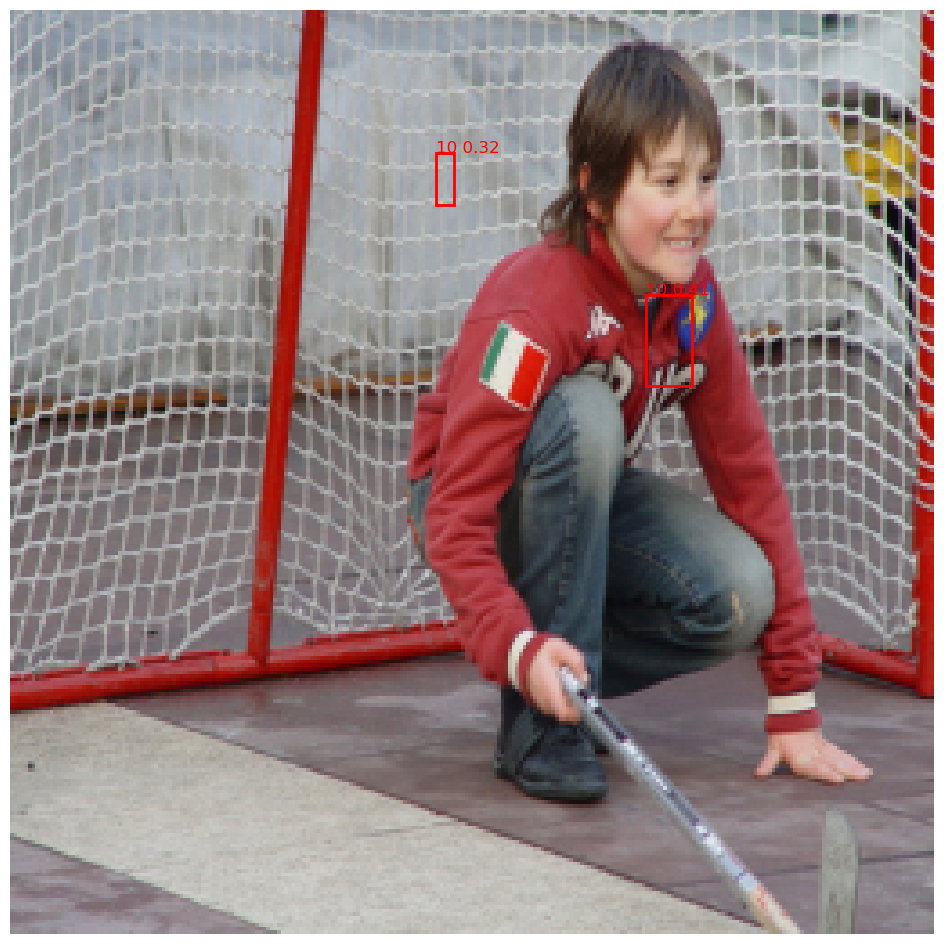

image shape: torch.Size([3, 224, 224])
image shape: (256, 256, 3)
No detections found for image 26 after confidence filtering.
image shape: torch.Size([3, 224, 224])
image shape: (256, 256, 3)
No detections found for image 27 after confidence filtering.
image shape: torch.Size([3, 224, 224])
image shape: (256, 256, 3)
No detections found for image 28 after confidence filtering.
image shape: torch.Size([3, 224, 224])
image shape: (256, 256, 3)
dimensions of image (256, 256, 3)
box coordinates: (13.120625, 64.28881, 223.58066, 224.86385)
box coordinates: (119.82535, 166.783, 148.91124, 193.79332)


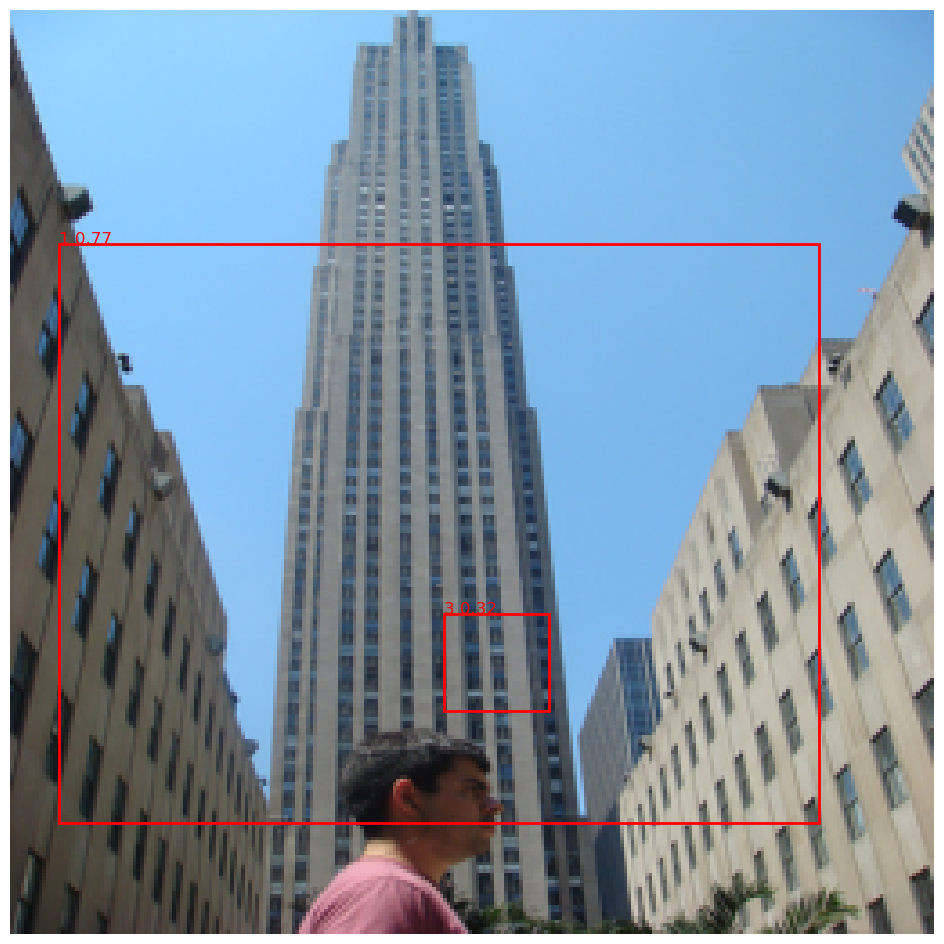

image shape: torch.Size([3, 224, 224])
image shape: (256, 256, 3)
dimensions of image (256, 256, 3)
box coordinates: (57.04513, 208.7574, 69.038734, 230.18619)
box coordinates: (57.183704, 209.27466, 69.170296, 233.8161)
box coordinates: (239.06985, 33.11538, 254.85278, 81.61373)


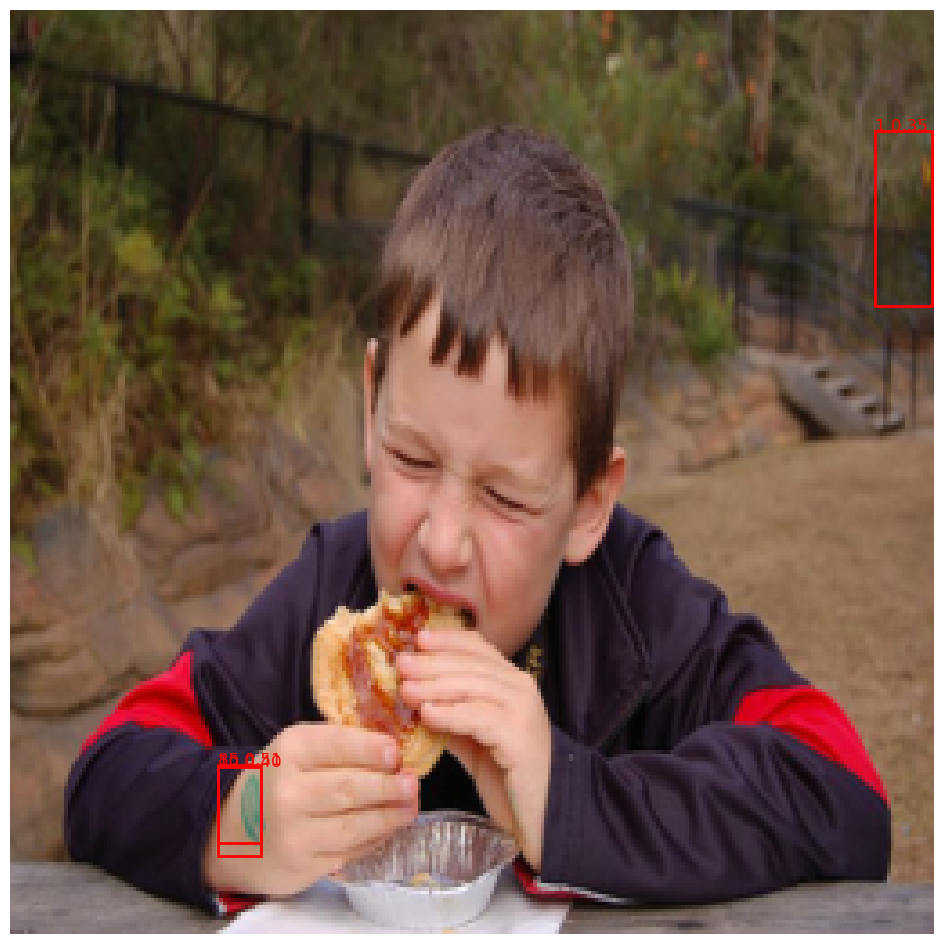

image shape: torch.Size([3, 224, 224])
image shape: (256, 256, 3)
dimensions of image (256, 256, 3)
box coordinates: (169.81595, 223.93199, 240.772, 249.68695)


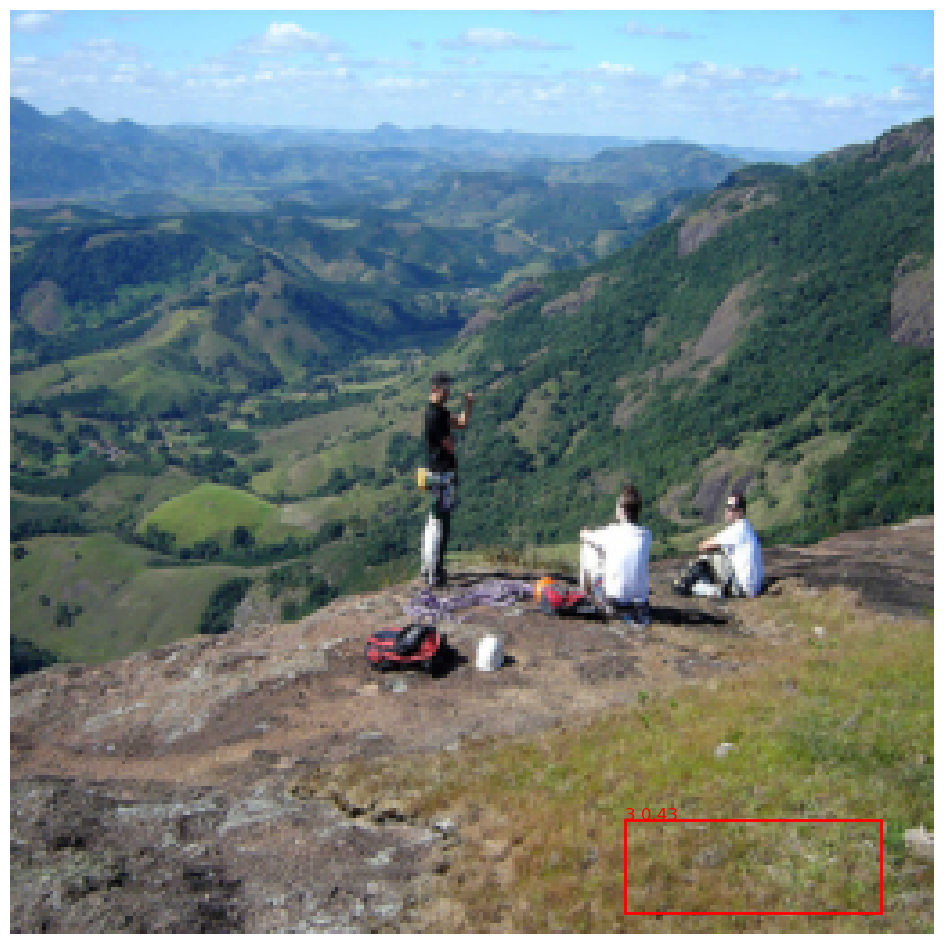

In [36]:
# show some inference results
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as T
from torchvision.ops import nms
import torchvision.transforms as transforms

def readImage(path, img_size=224):
    transform = transforms.Compose(
        [
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),  # Converts image to PyTorch Tensor and normalizes between 0 and 1
        ]
    )
    img = Image.open(path).convert("RGB")
    img = transform(img)
    return img.permute(
        1, 2, 0
    ).numpy()  # Permute to (H, W, C) for matplotlib compatibility


def plot_image(image, boxes, labels, scores):
    fig, ax = plt.subplots(1, figsize=(12, 12))
    ax.imshow(image)
    print(f"dimensions of image {image.shape}")
    for box, label, score in zip(boxes, labels, scores):
        x1, y1, x2, y2 = box
        print(f"box coordinates: {x1, y1, x2, y2}")
        rect = plt.Rectangle(
            (x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor="red", linewidth=2
        )
        ax.add_patch(rect)
        ax.text(x1, y1, f"{label} {score:.2f}", color="red", fontsize=12)
    plt.axis("off")
    plt.show()


for i, detection in enumerate(detections):
    boxes = detection["boxes"]
    scores = detection["scores"]
    labels = detection["labels"]

    # replace image with the actual image
    print(f"image shape: {images[i].shape}")
    image = readImage(image_dir + "/" + image_names[i], 256)
    print(f"image shape: {image.shape}")
    conf_thresh = 0.3
    keep = scores > conf_thresh  # Filter out low confidence detections
    if keep.sum() == 0:
        print(f"No detections found for image {i} after confidence filtering.")
        continue

    boxes_keep = boxes[keep]
    scores_keep = scores[keep]
    labels_keep = labels[keep]

    # Keep only top 32 scoring predictions
    keep = torch.argsort(scores_keep, descending=True)[:min(32, len(scores_keep))]
    boxes_keep, scores_keep, labels_keep = boxes_keep[keep], scores_keep[keep], labels_keep[keep]
    boxes_keep = boxes_keep.detach().numpy()
    labels_keep = labels_keep.detach().numpy()
    scores_keep = scores_keep.detach().numpy()

    if len(boxes_keep) > 0:
        # Plot the first image with at least one detection
        # image = T.ToPILImage()(image)
        plot_image(image, boxes_keep, labels_keep, scores_keep)
        
    else:
        print(f"No detections found for image {i} after top-k filtering.")


In [13]:
detections[0]

{'boxes': tensor([[  4.9377,  84.6891, 163.9123, 249.7715],
         [  0.0000,   8.5696, 211.9121, 188.6288],
         [  0.0000,  87.3349, 198.6664, 247.2490],
         [123.0402, 240.8983, 147.0703, 255.8129],
         [194.0357, 148.1689, 250.7906, 231.8833],
         [ 44.2410,  37.8075,  57.6249,  49.9493],
         [131.2316,   0.9208, 203.8491, 113.6005]]),
 'labels': tensor([ 1,  3,  3,  1, 70,  1, 10]),
 'scores': tensor([0.0968, 0.0823, 0.0746, 0.0654, 0.0597, 0.0595, 0.0551])}

In [23]:
boxes[0]

tensor([[ 71.1266, 647.8240, 138.6259, 675.9510],
        [ 90.8095, 306.1318, 119.5237, 426.2411],
        [ 73.4191, 647.8556, 136.7758, 674.1085],
        [ 75.5610, 307.6855, 800.0000, 783.4834],
        [ 74.5464, 645.1444, 136.3199, 672.4888],
        [218.0916, 273.9238, 800.0000, 788.4260],
        [239.3088, 266.0416, 798.3476, 800.0000]], grad_fn=<IndexBackward0>)

In [24]:
scores[0]

tensor([0.2232, 0.1970, 0.1865, 0.1143, 0.0810, 0.0558, 0.0514],
       grad_fn=<IndexBackward0>)

In [25]:
labels[0]

tensor([ 3, 10, 81,  3, 51,  2, 70])

In [28]:
box_features[0].shape

torch.Size([1024])